In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))
print(f"notebook_dir: {notebook_dir}")
print(f"Calculated project_root: {project_root}")
print(f"Current sys.path (before modification): {sys.path}")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

notebook_dir: d:\02_Projects\Dev\ReflectoLearn\notebooks
Calculated project_root: d:\02_Projects\Dev\ReflectoLearn
Current sys.path (before modification): ['C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\python312.zip', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\DLLs', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\Lib', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv', '', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages', 'D:\\02_Projects\\Dev\\ReflectoLearn\\src', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages\\win32', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages\\win32\\lib', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages\\Pythonwin']


In [2]:
%reload_ext autoreload
%autoreload 2

In [11]:
import numpy as np

from reflectolearn.data_processing.simulate import make_multifilm


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scp
import scipy.optimize as optimize
import scipy.signal.windows as fft_windows
from pylab import *
from scipy import *


def XRR(data, crit_ang):
    """
    Returns equally spaced data for the Fourier analysis of a typical XRR dataset.
    Data must be an array with 2 Theta angle in the first column and the intensity in the second column
    """

    # rescale x-axis to get at the end nm from the FFT (introduce diffraction vector: s_cor)
    s_cor = 2 * np.sqrt((np.cos(np.pi * crit_ang / 2 / 180)) ** 2 - (np.cos(np.pi * data[:, 0] / 2 / 180)) ** 2) / 0.152

    # mask all entrys which are 'nan' due to values below the critical angle
    mask = np.logical_not(np.isnan(s_cor))
    s_cor = s_cor[mask]

    # subtract a background of 'theta^4 * intensity'
    intensity = s_cor**4 * data[mask, 1]

    # TODO: Check if this is necessary
    s_cor, unique_idx = np.unique(s_cor, return_index=True)
    intensity = intensity[unique_idx]

    # create new x wave with even spacing going from the lowest
    # to the highest diffraction vector
    x = np.linspace(s_cor.min(), s_cor.max(), 1000)
    f = scp.interpolate.interp1d(s_cor, intensity, kind="cubic")
    return x, f(x)


def XRR_q(data_q, q_crit):
    q_nm = data_q[:, 0]
    R = data_q[:, 1]
    q_c_nm = q_crit

    s_cor = np.sqrt(q_c_nm**2 - q_nm**2)
    mask = np.isfinite(s_cor)
    s_cor = s_cor[mask]
    intensity = s_cor**4 * R[mask]

    s_cor, unique_idx = np.unique(s_cor, return_index=True)
    intensity = intensity[unique_idx]

    if len(s_cor) < 4:
        raise ValueError(f"Not enough points ({len(s_cor)}) for cubic interpolation.")

    kind = "cubic" if len(s_cor) >= 4 else "linear"
    x = np.linspace(s_cor.min(), s_cor.max(), 1000)
    f = scp.interpolate.interp1d(s_cor, intensity, kind=kind)

    return x, f(x)


def FFT(x, y, d=None, window=2, n=None):
    """
    Performs a (real) FFT using no window (0), a hanning (1), a hamming (2) or flattop (otherwise) window.
    d is data spacing; if no d is given, the spacing of the first two data values in x is taken
    x data have to be equaly spaced!
    n = number of values taken into account, if n<len(y): data are cropped; if n>len(y): data are zero-padded
    returns only one half of the full FFT (1st quadrant)
    """
    if d is None:
        d = x[1] - x[0]
    N = len(y)
    # declaration of window functions
    if 0 == window:
        window = np.ones(N)
    elif 1 == window:
        window = fft_windows.hann(N)
    elif 2 == window:
        window = fft_windows.hamming(N)
    else:
        window = fft_windows.flattop(N)
    if n is None:
        n = N
    # calculate fft with all correction factors:
    # 2/N: up front to renormalize the FFT
    # mean(window): window correction factor
    yf = 2 / N * np.abs(scp.fftpack.fft(window * y / np.mean(window), n=n))
    # Calculate the frequency axis
    xf = scp.fftpack.fftfreq(n, d=d)
    return xf[: n // 2], yf[: n // 2]


hc = 12.398


def tth2qz_by_energy(tth_deg, energy):
    th_rad = np.deg2rad(tth_deg / 2)
    return 4 * np.pi * np.sin(th_rad) * energy / hc

In [5]:
# ====================== Fitting Functions ====================== #
def funcNoise(x, amp, ex):
    """1/f 노이즈 모델"""
    return amp / np.power(x, ex)


def funcGauss(p, a, pmax, w):
    """단일 Gaussian"""
    return a * exp(-log(2) * ((pmax - p) / (w / 2)) ** 2)


def funcGauss2(p, a1, a2, pmax1, pmax2, w1, w2):
    """2중 Gaussian"""
    return funcGauss(p, a1, pmax1, w1) + funcGauss(p, a2, pmax2, w2)


def funcGauss3(p, a1, w1, a2, pmax2, w2, a3, pmax3, w3, amp, ex, z0):
    """3중 Gaussian + 1/f 노이즈"""
    pmax1 = pmax3 - pmax2
    return funcGauss2(p, a1, a2, pmax1, pmax2, w1, w2) + funcGauss(p, a3, pmax3, w3) + funcNoise(p, amp, ex) + z0


def estimate_qc(q, R, smooth_window=5):
    # 로그스케일 반사율
    logR = np.log(R)
    # 이동 평균으로 smoothing
    logR_smooth = np.convolve(logR, np.ones(smooth_window) / smooth_window, mode="same")
    # 기울기 계산
    dlogR = np.gradient(logR_smooth, q)
    # 기울기 절댓값이 최대인 지점의 q
    idx = np.argmax(np.abs(dlogR))
    return q[idx]


# ====================== Main Process ====================== #
def analyze_xrr_fft(dat, crit_q):
    # FFT 전처리
    q_uniform, intensity_uniform = XRR_q(dat, crit_q)
    fft_x, fft_y = FFT(q_uniform, intensity_uniform, window=2, n=10000)
    fft_y_norm = fft_y / fft_y[0]

    # 마스크 생성
    mask_bg = logical_or(logical_and(fft_x > 1, fft_x < 5), logical_and(fft_x > 26, fft_x < 80))
    mask_full = logical_and(fft_x > 1.1, fft_x < 80)

    # 1/f 백그라운드 피팅
    popt_noise, _ = optimize.curve_fit(funcNoise, fft_x[mask_bg], fft_y_norm[mask_bg])

    # Gaussian + Noise 피팅
    p0 = [0.2, 0.3, 0.2, 7, 0.3, 0.2, 13, 0.3, 1, 2, 2e-3]
    bounds = (0, inf)
    popt_gauss3, _ = optimize.curve_fit(funcGauss3, fft_x[mask_full], fft_y_norm[mask_full], p0=p0, bounds=bounds)

    return fft_x, fft_y_norm, popt_noise, popt_gauss3


# ====================== Plotting ====================== #
def plot_xrr_fft(fft_x, fft_y_norm, popt_gauss3):
    fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6))

    # 원 데이터
    ax[0].plot(fft_x, fft_y_norm, "o-", ms=1, lw=0.7, color="dimgrey", label="FFT data")
    ax[1].plot(fft_x, fft_y_norm, "o-", ms=1, lw=0.7, color="dimgrey")

    # 전체 피팅
    ax[0].plot(
        fft_x,
        funcGauss3(fft_x, *popt_gauss3),
        "-",
        color="goldenrod",
        label="Multi-Gaussian fit",
    )

    # 개별 Gaussian
    ax[1].plot(
        fft_x,
        funcGauss(fft_x, *popt_gauss3[2:5]),
        "--",
        color="darkblue",
        label="Gaussian 1",
    )
    ax[1].plot(
        fft_x,
        funcGauss(fft_x, popt_gauss3[0], popt_gauss3[6] - popt_gauss3[3], popt_gauss3[1]),
        "--",
        color="purple",
        label="Gaussian 2",
    )
    ax[1].plot(
        fft_x,
        funcGauss(fft_x, *popt_gauss3[5:8]),
        "--",
        color="teal",
        label="Gaussian 3",
    )
    ax[1].plot(
        fft_x,
        funcNoise(fft_x, *popt_gauss3[8:10]),
        "--",
        color="chocolate",
        label="1/f noise",
    )

    # 설정
    ax[0].set_ylabel("Normalized FFT amplitude")
    ax[1].set_xlabel("Thickness (nm)")
    ax[0].set_xlim(0, 80)
    ax[0].set_ylim(0, 1.1)
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()

Q range [0.04982673934962419, 0.21352010405098396]
Critical Q: 0.21186695476890507


C:\Users\isaac\AppData\Local\Temp\ipykernel_19560\1940224618.py:42: RuntimeWarning: invalid value encountered in sqrt
  s_cor = np.sqrt(q_c_nm**2 - q_nm**2)
C:\Users\isaac\AppData\Local\Temp\ipykernel_19560\881460143.py:4: RuntimeWarning: divide by zero encountered in divide
  return amp / np.power(x, ex)


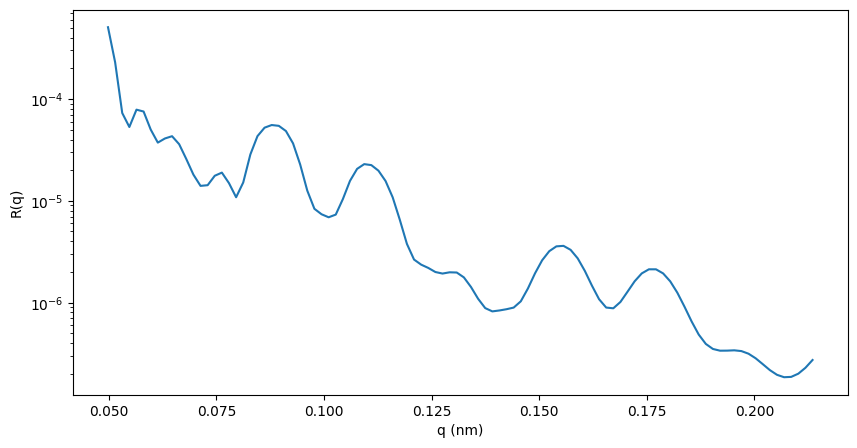

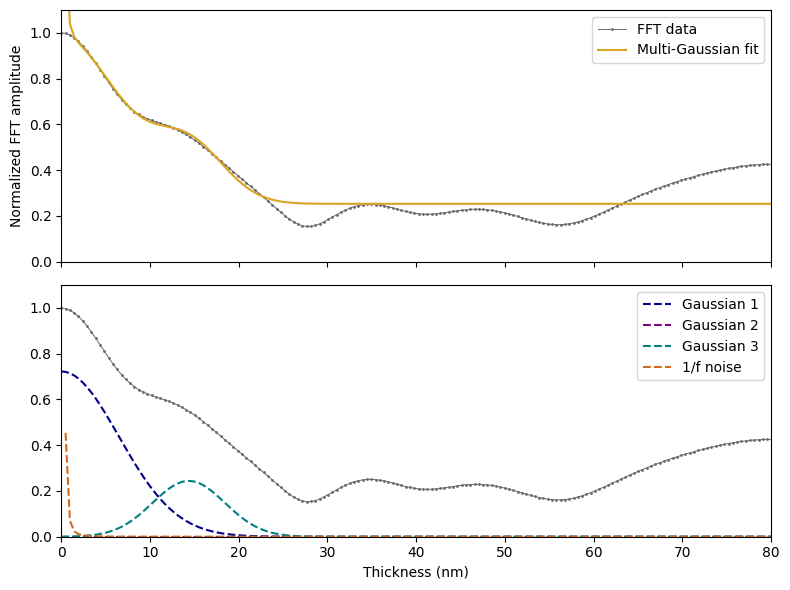

Gaussian fit results:
- a1: 0.00, p1: 14.37 nm, w1: 0.81 nm
- a2: 0.72, p2: 0.00 nm, w2: 15.29 nm
- a3: 0.24, p3: 14.37 nm, w3: 9.60 nm
- Noise amp: 0.07, exp: 2.67, z0: 0.25


In [25]:
beam_energy = 8.04751

tth = np.linspace(0.7, 3, 100)
q = tth2qz_by_energy(tth, beam_energy)
print(f"Q range [{q.min()}, {q.max()}]")
data = make_multifilm(3, q, add_noise=False)
dat = np.stack([q, data["R"]], axis=1)

# crit_q = 0.1

crit_q = estimate_qc(q, data["R"])
print(f"Critical Q: {crit_q}")
fft_x, fft_y_norm, popt_noise, popt_gauss3 = analyze_xrr_fft(dat, crit_q)

# XRR Graph
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(dat[:, 0], dat[:, 1], "", label="data")
ax.set_yscale("log")
ax.set_xlabel("q (nm)")
ax.set_ylabel("R(q)")

# FFT Gaussian Graph
plot_xrr_fft(fft_x, fft_y_norm, popt_gauss3)

# Gaussian fit results
print("Gaussian fit results:")
print(f"- a1: {popt_gauss3[0]:.2f}, p1: {popt_gauss3[6] - popt_gauss3[3]:.2f} nm, w1: {popt_gauss3[1]:.2f} nm")
print(f"- a2: {popt_gauss3[2]:.2f}, p2: {popt_gauss3[3]:.2f} nm, w2: {popt_gauss3[4]:.2f} nm")
print(f"- a3: {popt_gauss3[5]:.2f}, p3: {popt_gauss3[6]:.2f} nm, w3: {popt_gauss3[7]:.2f} nm")
print(f"- Noise amp: {popt_gauss3[8]:.2f}, exp: {popt_gauss3[9]:.2f}, z0: {popt_gauss3[10]:.2f}")